# Modulation - General Aspects & Graphics

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
figsize_1 = (12/2.54,6/2.54)

## Define Parameters

Samplerate and -period, at which all signals in this notebook are represented

In [4]:
f_s = 10e3;
T_s = 1/f_s;

Simulation duration and simulation time vector

In [5]:
T_sim = 1;
t_sim = np.arange(0,T_sim,T_s)

# Define Source Signals

In [6]:
f_source_analog = 2;
sig_source_analog = np.sin(2*np.pi*f_source_analog*t_sim);

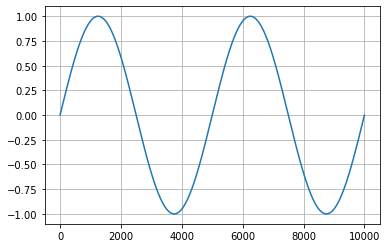

In [7]:
plt.figure()
plt.plot(sig_source_analog)
plt.grid()
plt.show()

## Frequency Modulation

### FM Moduation Signal
According to [Kammeyer], the general expression of a frequency-modulated signal is given by

$$
x_{FM}(t) = a_0 cos{ \left( \psi(t)+\varphi_0 \right)},
$$

where $\psi(t)$ is the instantaneous phase of the FM signal.
The instantaneous phase is related to the source signal $v(t)$ by

$$
\psi(t) = \omega_0 t + \Delta \Omega \int\limits_{0}^{t}v(t')dt' + \psi_0
$$

In this notebook, we first do an intermediate calculation of the above integral and refer to it as `fm_modulation_signal`.
Do to numeric integration by a cumulative sum, a resulting DC component is removed and the signal is normalized to its maximum value.


In [8]:
fm_modulation_signal = (np.cumsum(sig_source_analog)-np.sum(np.cumsum(sig_source_analog))/len(np.cumsum(sig_source_analog)))/max(np.cumsum(sig_source_analog));

The carrier frequency of the FM signal

In [9]:
f_c = f_s/500;

The modulation index $\Delta \Omega$ is define relative to the carrier frequency

In [10]:
delta_omega = 0.1 * f_c;

And the resulting FM signal

In [11]:
sig_fm  = np.sin(2*np.pi*f_c*t_sim + 2*np.pi*delta_omega*fm_modulation_signal);

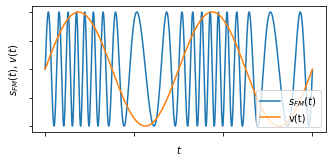

In [12]:
fig = plt.figure()
fig.set_size_inches(figsize_1)

ax1 = plt.subplot(1,1,1)

plt.plot(t_sim, sig_fm, label="$s_{FM}(t)$")
plt.plot(t_sim, sig_source_analog, label="v(t)")
plt.xticks(np.linspace(t_sim[0], t_sim[-1], 4),[])
plt.yticks(np.arange(-1,1.5,0.5),[])
plt.xlabel('$t$')
plt.ylabel('$s_{FM}(t)$, $v(t)$')
plt.legend(loc = "lower right")
fig.tight_layout()
plt.savefig('modulation_fm', dpi = 300)
plt.show()

## Analog PAM Modulation

Symbol-/Samplerate of analog PAM signal

In [13]:
f_symb = f_source_analog*8
T_symb = 1/f_symb

In [14]:
N_step = round(T_symb / T_s)
N_start = round(0.2*N_step)

In [15]:
sig_pam_analog = np.zeros(sig_source_analog.shape)
sig_pam_analog[N_start::N_step] = sig_source_analog[N_start::N_step]

In [16]:
g_t_pam_analog = np.ones((N_step))*np.exp(-np.arange(0, N_step)/N_step/8)

In [17]:
sig_pam_analog = np.convolve(sig_pam_analog, g_t_pam_analog)
sig_pam_analog = sig_pam_analog[0:-len(g_t_pam_analog)+1]

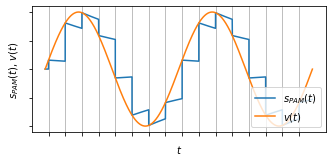

In [18]:
fig = plt.figure()
fig.set_size_inches(figsize_1)
plt.plot(t_sim, sig_pam_analog, label = "$s_{PAM}(t)$")
plt.plot(t_sim, sig_source_analog, label = "$v(t)$")
plt.xlabel("$t$")
plt.ylabel('$s_{PAM}(t)$, $v(t)$')
plt.legend(loc = "lower right")
plt.xticks(t_sim[N_start::N_step],[])
plt.yticks(np.arange(-1,1.5,0.5),[])
plt.grid(axis="x")
fig.tight_layout()
plt.savefig('modulation_pam_analog', dpi = 300)
plt.show()

## Digital PAM Modulation

Define the sequence of source symbols

In [19]:
seq_source_digital = np.array([1,-2,-1,3])
display(f"Sequence of source symbols has shape {seq_source_digital.shape}")

'Sequence of source symbols has shape (4,)'

In this notebook, source symbols should fit into the simulated tim duration; hence the symbol duration `T_symb` is selected that the number of defined symbols exactly are represented in the simulation; add two zero symbols at start and end to center the sequence of desired symbols

In [20]:
N_symbols = len(seq_source_digital)
T_symb_desired = T_sim/N_symbols

display(f"Simulation duration: {T_sim} [s]")
display(f"Number of Symbols in simulation: {N_symbols}")
display(f"Desired symbol duration: {T_symb_desired} [s]")

'Simulation duration: 1 [s]'

'Number of Symbols in simulation: 4'

'Desired symbol duration: 0.25 [s]'

How many samples of simulation time represent on symbol?

In [21]:
N_samples_per_symbol = round(T_symb_desired/T_s)
T_symb = N_samples_per_symbol*T_s

display(f"Upsampling ratio: {N_samples_per_symbol} [Samples/Symbol]")
display(f"Symbol duration: {T_symb} [s]")

'Upsampling ratio: 2500 [Samples/Symbol]'

'Symbol duration: 0.25 [s]'

Upsample the sequence of source symbols such that each symbols takes duration of `T_symb`; therefore represent sequence of source symbols as an array of shape (1, `N_symbols`), append an array of shape (`N_samples_per_symbol-1`, `N_symbols`) and flatten the array to a vector in Fortran (column-major) order.

In [22]:
sig_source_digital = np.concatenate((np.atleast_2d(seq_source_digital), np.zeros([N_samples_per_symbol-1,len(seq_source_digital)]))).flatten('F')

Define the transmit impulse

In [23]:
T_g_t = T_symb
t_t = np.arange(-T_sim, T_sim,T_s)
g_t = np.sinc(t_t/(0.25*T_symb))
#g_t = np.sinc(t_t/(0.25*T_symb))*np.cos(2*np.pi*f_c*t_t)

Plot the transmit pulse

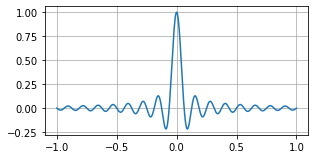

In [24]:
fig = plt.figure()
fig.set_size_inches(figsize_1)
ax1 = plt.subplot(1,1,1)
ax1.plot(t_t, g_t)
plt.grid()
plt.show()

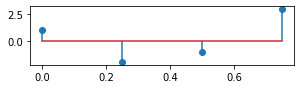

In [25]:
fig = plt.figure()
fig.set_size_inches(figsize_1)
ax1 = plt.subplot(2,1,1)
#ax1.plot(t_sim, sig_source_digital)
ax1.stem(t_sim[sig_source_digital != 0], sig_source_digital[sig_source_digital != 0], use_line_collection = True)
plt.show()

### Generate the transmit signal
The transmit signal is generated by convolving the transmit impulse with the upsampled sequence of transmit symbols.

In [26]:
tx_sig = np.convolve(g_t, sig_source_digital)

Remove the transients of filtered signal

In [27]:
# remove the initial transient from filter
tx_sig = tx_sig[round(t_t.shape[0]/2):]
# remove the end transients
tx_sig = tx_sig[:sig_source_digital.shape[0]]

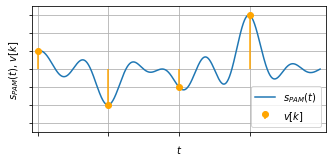

In [28]:
fig = plt.figure()
fig.set_size_inches(figsize_1)

ax1 = plt.subplot(1,1,1)
plt.plot(t_sim, tx_sig, label = "$s_{PAM}(t)$")
markerline, stemlines, baseline = ax1.stem(t_sim[sig_source_digital != 0],
                                           sig_source_digital[sig_source_digital != 0],
                                           use_line_collection = True,
                                           basefmt=" ",
                                           label = "$v[k]$")
plt.setp(stemlines, "color", "orange")
plt.setp(markerline, "color", "orange")
plt.xticks(np.arange(0,len(seq_source_digital))*T_symb, "")
plt.yticks(np.arange(-3,4), "")
ax1.set_xlim(-200*T_s,t_sim[-1]+200*T_s)
ax1.set_ylim(-3.5,3.5)
plt.xlabel('$t$')
plt.ylabel('$s_{PAM}(t)$, $v[k]$')

plt.grid()
plt.legend(loc="lower right")
fig.tight_layout()
plt.savefig('modulation_pam', dpi = 300)
plt.show()

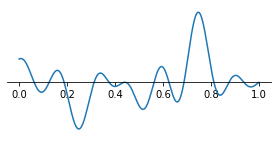

In [45]:
fig = plt.figure()
fig.set_size_inches(figsize_1)

ax1 = plt.subplot(1,1,1)
plt.plot(t_sim, tx_sig, label = "$s_{PAM}(t)$")
ax1.xaxis.set_visible(True)
ax1.yaxis.set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_position("zero")
plt.savefig('modulation_pam_clean', dpi = 300)
plt.show(fig)